# ДЗ 4

In [1]:
import warnings
warnings.filterwarnings("ignore") # отключает предупреждения

import numpy as np
import pandas as pd 

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression

import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
%matplotlib inline

def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0]).resample('W').mean()

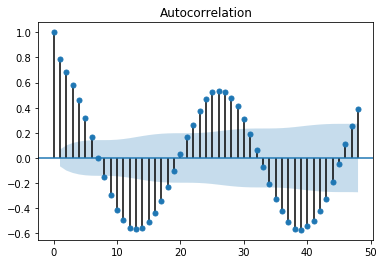

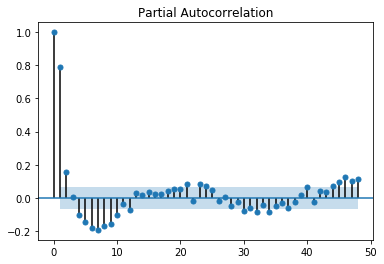

In [3]:
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=48)
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=48)
plt.show()

### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

In [8]:
def createFeatures(data, p=7):
    df = data.drop(['year', 'hour', 'dayofyear', 'dayofmonth', 'dayofweek'], axis=1).copy()
    
    scl = StandardScaler()
    tsne = TSNE(n_components=2)

    X = df.iloc[:,:-1]
    X = scl.fit_transform(X)
    Xt = tsne.fit_transform(X)

    clast_0 = DBSCAN(eps=5, leaf_size=15)
    clast_1 = DBSCAN(eps=2, leaf_size=5)

    df['cluster1'] = clast_0.fit_predict(Xt)
    df['cluster2'] = clast_1.fit_predict(X)
    
    pca = PCA(n_components=2, svd_solver='full')
    Xpca=pca.fit_transform(X)
    
    df['pca1']=Xpca[:,0]
    df['pca2']=Xpca[:,1]
    
    df['diff1'] = df.iloc[:, 0].diff()
    df['diff1'].fillna(0, inplace=True)

    for i in range(1, p):
        df[f't{i}'] = 0.0
        df[f't{i}'].values[i:] = df['PJME_MW'].values[:-i]
        df[f'd{i}'] = 0.0
        df[f'd{i}'].values[i:] = df['diff1'].values[:-i]

    for i in range(1,9):
        df[f'exp_0{i}'] = exponential_smoothing(df['PJME_MW'], i/100)
        
    return df

def getXy(df, h, p=7):
    scl_target = StandardScaler() 
    target = df['PJME_MW'].values[h+p:].reshape((df.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)

    scl_x=StandardScaler() 
    X = df.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))
    return X, y, scl_target

def getFeatures(X, y):
    
    sfk = SelectKBest(f_regression, k=5)
    sfk.fit_transform(X, y.ravel())

    sfp=SelectPercentile(f_regression, percentile=10)
    sfp.fit_transform(X, y.ravel())

    gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = 5)
    sfm.fit_transform(X, y.ravel())

    list_param_k =np.where(sfk.get_support())[0]
    list_param_p =np.where(sfp.get_support())[0]
    list_param_m =np.where(sfm.get_support())[0]

    features = list(set(list(list_param_k) + list(list_param_m) + list(list_param_p)))

    print('Номера признаков k лучших признаков : ',list_param_k)
    print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
    print('Номера признаков для выбора по модели : ',list_param_m)

    print('Отобранные признаки: ',list(df.columns[features]))
    
    return features

def modeling(X, y, train, test, features):
    X_new = X[:,features]

    X_train =X_new[:train.shape[0],:]
    y_train =y[:train.shape[0],0]
    X_test =X_new[train.shape[0]:,:]
    y_test =y[train.shape[0]:,0]


    model = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
    model.fit( X_train, y_train )
    y_pred = model.predict(X_test)

    plt.figure( figsize=( 15, 7 ))


    plt.xlabel('Время')
    plt.ylabel('Потребление энергии, МВт')
    plt.plot(test.index[h+p:],y_pred, label='predict GB data' )
    plt.plot(test.index[h+p:],y_test, label='test data')

    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true = scl_target.inverse_transform(y_test),
                                          y_pred = scl_target.inverse_transform(y_pred))

    print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

Номера признаков k лучших признаков :  [ 0 12 15 20 22]
Номера признаков лучших признаков по процентной форме:  [ 0 12 20 22]
Номера признаков для выбора по модели :  [ 0  1  3  9 22]
Отобранные признаки:  ['PJME_MW', 'month', 'weekofyear', 'pca1', 't1', 'd2', 't5', 't6']


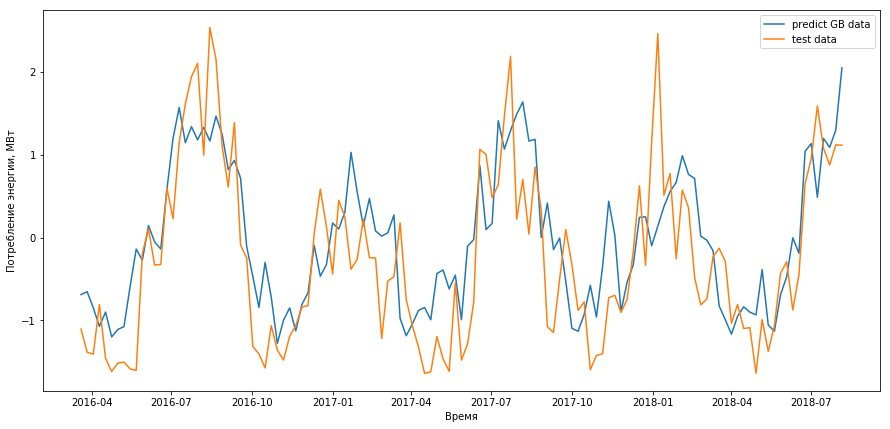

ошибка градиентного бустинга MAPE :   7.421774487700539 %


In [9]:
def split_data( data, year):
    return data.loc[data.index.year < year].copy(), data.loc[data.index.year >=  year].copy()

h = 4
p = 7

df = createFeatures(data, p)
X, y, scl_target = getXy(df, h, p)
features = getFeatures(X, y)

train, test = split_data( df, 2016)

modeling(X, y, train, test, features)

### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

Номера признаков k лучших признаков :  [ 0 12 14 16 18]
Номера признаков лучших признаков по процентной форме:  [ 0 12 14 16]
Номера признаков для выбора по модели :  [0]
Отобранные признаки:  ['PJME_MW', 't1', 't2', 't3', 't4']


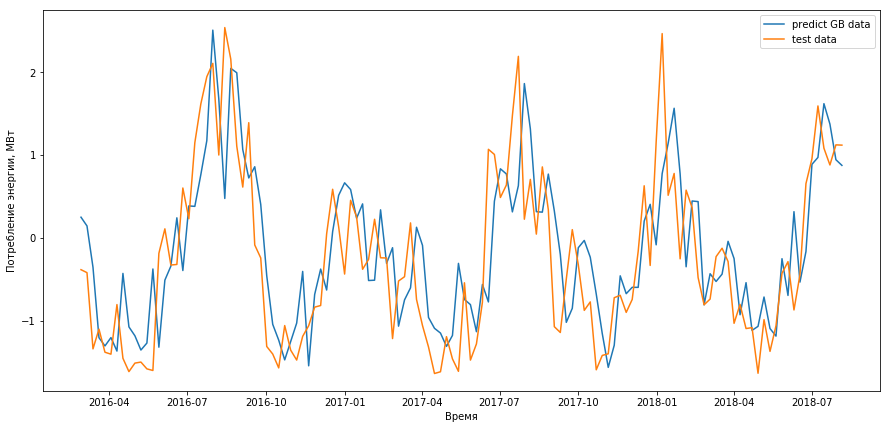

ошибка градиентного бустинга MAPE :   7.254024372566556 %


In [11]:
h = 1
p = 7

df = createFeatures(data, p)
X, y, _ = getXy(df, h, p)
features = getFeatures(X, y)
modeling(X, y, train, test, features)

### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 

In [12]:
h = 1
p = 7

df = createFeatures(data, p)
X, y, _ = getXy(df, h, p)
features = getFeatures(X, y)

X_new = X[:,features]

X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]


model = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit( X_train, y_train )
y_pred = model.predict(X_test)

Номера признаков k лучших признаков :  [ 0 12 14 16 18]
Номера признаков лучших признаков по процентной форме:  [ 0 12 14 16]
Номера признаков для выбора по модели :  [0]
Отобранные признаки:  ['PJME_MW', 't1', 't2', 't3', 't4']


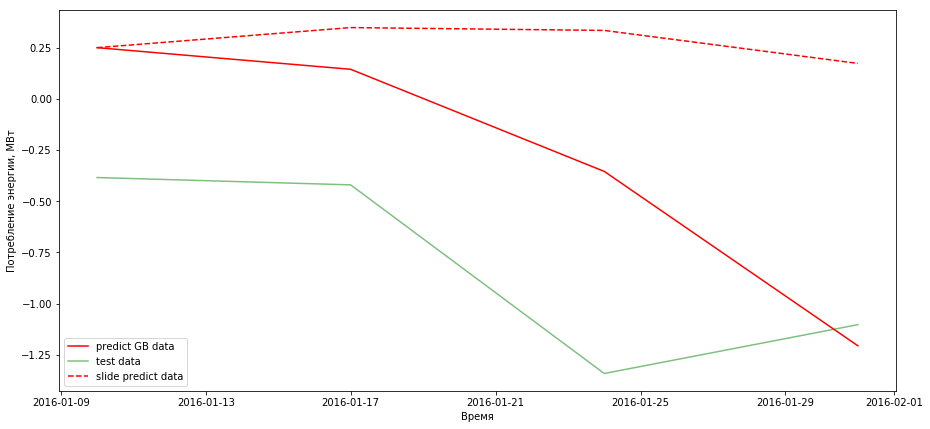

ошибка градиентного бустинга MAPE :   15.459632664684259 %


In [13]:
X_test_100 = X_test.copy()
y_test_100 = y_pred.copy()
N = 4
sph = len(features)

for i in range(N):
    y_test_100[i] = model.predict(X_test_100[i,:].reshape((1,sph)))
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = y_test_100[i]
    X_test_100[i+1,1] = X_test_100[i, 0]
    X_test_100[i+1,2] = 0 if i<2 else X_test_100[i-2, 0]
    X_test_100[i+1,3] = 0 if i<3 else X_test_100[i-3, 0]
    X_test_100[i+1,4] = 0 if i<4 else X_test_100[i-4, 0]
        
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N+1],y_pred[:N], 'r',label='predict GB data' )
plt.plot(test.index[1:N+1],y_test[:N], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N+1],y_test_100[:N], '--r',label='slide predict data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true = scl_target.inverse_transform( y_test[:N]),
                                      y_pred = scl_target.inverse_transform( y_test_100[:N]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

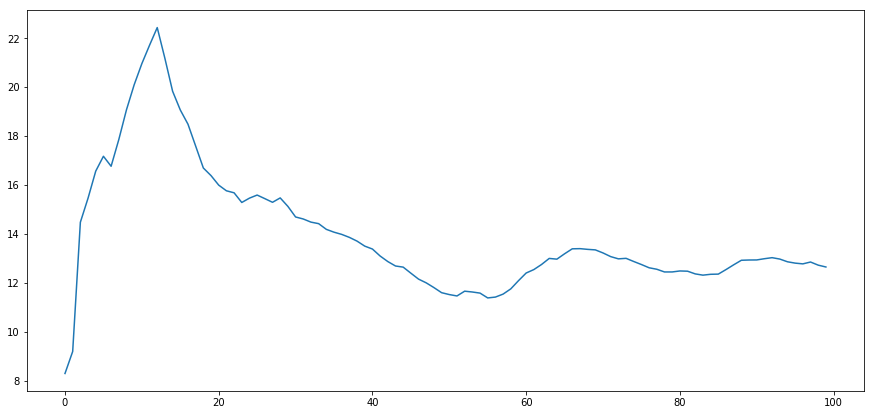

In [14]:
def eta(N):
    X_test_100 = X_test.copy()
    y_test_100 = y_pred.copy()
    sph = len(features)
    for i in range(N):
        y_test_100[i] = model.predict(X_test_100[i,:].reshape((1,sph)))
        # заполняем вектор для прогноза следующей точки
        X_test_100[i+1,0] = y_test_100[i]
        X_test_100[i+1,1] = X_test_100[i, 0]
        X_test_100[i+1,2] = 0 if i<2 else X_test_100[i-2, 0]
        X_test_100[i+1,3] = 0 if i<3 else X_test_100[i-3, 0]
        X_test_100[i+1,4] = 0 if i<4 else X_test_100[i-4, 0]

    return mean_absolute_percentage_error(y_true = scl_target.inverse_transform( y_test[:N]),
                                          y_pred = scl_target.inverse_transform( y_test_100[:N]))

n = []
for i in range(1, 101):
    n.append(eta(i))

plt.figure( figsize=( 15, 7 ))
plt.plot(n)
plt.show()

### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Если я правильно все сделал и правильно все понял то так как моя модель получается зависит в основном от предидущих значений t1-t4 то ошибка на начальных точках от 5 по 20 выше так как предидущих данных нет но чем дальше тем ошибка уменьшатся и можно считать стабилизируется